In [6]:
from copy import deepcopy

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cmocean.cm import thermal, thermal_r

from inlifesim.bootstrapping import EvaluateBootstrapping

In [9]:
#Direct input
plt.rcParams['text.latex.preamble']=r'\usepackage{lmodern} \usepackage{amsmath}'

#Options
params = {'text.usetex' : True,
          'font.size' : 8,
          'font.family' : 'lmodern',
          # 'text.latex.unicode': True,
          }
plt.rcParams.update(params)

In [10]:
paths = ['/Users/fdannert/Documents/projects/InLIFEsim/working/paper/FINAL_DATA/1e10_v3/']

ev = EvaluateBootstrapping(verbose=False,
                           paths=paths,
                           bootstrap_properties={'B': int(1e10),
                                                 'N': 50,
                                                 'log_sampling_max': 3})

print('Extrapolating logistic parameters', end='')
ev.extrapolate_logistic_parameters(sigma_actual_shape=(1.8, 7.8, 200),
                                   start_fit_at_sigma=[3, 3, 5, 2.5],
                                   end_fit_at_sigma=[5, 5, 7, 7.5],
                                   polynomial_order=[1, 1, 1, 2])
print('[Done]')

print('Creating large lookup table', end='')
ev.create_lookup_table(sigma_actual_shape=(0.2, 7., 200),
                            sigma_analytical_shape=(0, 8, 1000),
                            sigma_ratio_shape=(-1., 0.75, 1000),
                            n_analytical=400,
                       table_name='large',
                       crit_value=6)
print('[Done]')

print('Creating large lookup table', end='')
ev.create_lookup_table(sigma_actual_shape=(0.07, 0.25, 200),
                        sigma_analytical_shape=(0, 0.25, 1000),
                        sigma_ratio_shape=(-1., 0.75, 1000),
                        n_analytical=400,
                       table_name='small',
                       crit_value=0.2,
                       initial_guess=[-0.29, 5.26, 0.08, 0.07],
                       update_guess=True,
                       make_n_plots=10)
print('[Done]')

print('Extrapolating lookup table', end='')
ev.create_extrapolated_lookup_table(sigma_actual_shape=(5, 30, 1000),
                                    sigma_ratio_shape=(-1., 0.75, 1000),
                                    sigma_analytical_shape=(3, 30, 1000))
print('[Done]')

# print('Saving lookup table')
# ev.save_lookup('/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/50_code/working/'
#         'paper/lookup_table/data/lookup_table_1e10_Nov24.pkl')
print('[Done]')

Extrapolating logistic parametersFailed at sigma_actual=1.8
Failed at sigma_actual=1.8301507537688442
Failed at sigma_actual=1.8603015075376885
Failed at sigma_actual=1.8904522613065327
Failed at sigma_actual=1.920603015075377
Failed at sigma_actual=1.9507537688442211
Failed at sigma_actual=1.9809045226130655
Failed at sigma_actual=2.0110552763819096
Failed at sigma_actual=2.0412060301507537
Failed at sigma_actual=2.071356783919598
Failed at sigma_actual=2.101507537688442
Failed at sigma_actual=2.1316582914572866
Failed at sigma_actual=2.1618090452261307
Failed at sigma_actual=2.191959798994975
Failed at sigma_actual=2.222110552763819
Failed at sigma_actual=2.252261306532663
Failed at sigma_actual=2.2824120603015077
Failed at sigma_actual=2.312562814070352
Failed at sigma_actual=2.342713567839196
Failed at sigma_actual=2.37286432160804
Failed at sigma_actual=2.403015075376884
Failed at sigma_actual=2.4331658291457288
Failed at sigma_actual=2.463316582914573
Failed at sigma_actual=2.493

IndexError: index 0 is out of bounds for axis 0 with size 0

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_12549/1164836763.py:20: RuntimeWarning: divide by zero encountered in log10
  if np.log10(si/sg) == -np.inf:
/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_12549/1164836763.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  if np.log10(si/sg) == -np.inf:
/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_12549/1164836763.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  elif np.log10(si/sg) == np.inf:


KeyError: 'extrapolation_ratio'

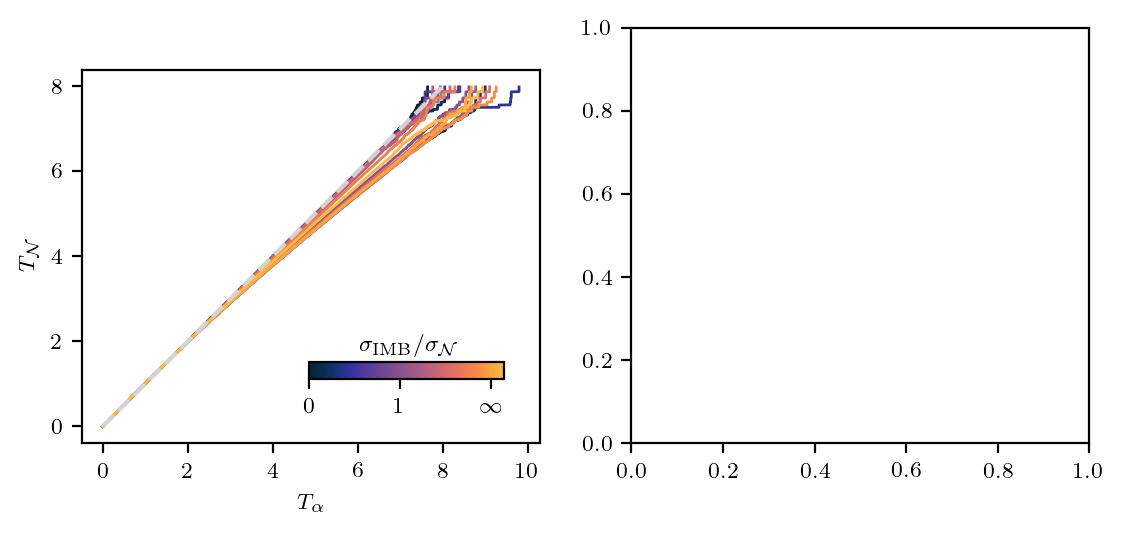

In [13]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(6.5, 2.7),
    dpi=200,
    gridspec_kw={
        'width_ratios': [1, 1],
        # 'wspace': 0.5,
    }
)

dax = ax[0]

lw = {'medium': 1,
      'small': 0.5,}

# extract N colors from the thermal colormap
colors = thermal(np.linspace(0, 0.85, len(ev.sigma_gauss)))

for sg, si, c in zip(ev.sigma_gauss, ev.sigma_bessel, colors):
    if np.log10(si/sg) == -np.inf:
        label='0'
    elif np.log10(si/sg) == np.inf:
        label='$\infty$'
    elif int(np.log10(si/sg)) == 0 and np.log10(si/sg) < 0:
        label=f'{np.round(si/sg, 2)}'
    elif int(np.log10(si/sg)) == 0 and np.log10(si/sg) >= 0:
        label=f'{int(np.round(si/sg, 0))}'
    else:
        label=f'$10^{{{int(np.log10(si/sg))}}}$'
    dax.plot(ev.sigma_want_get[(sg, si)][1], ev.sigma_want_get[(sg, si)][0],
             # format the labels in scientific notation
             #    label=label,
            color=c,
             lw=lw['medium']
            )

dax.plot(ev.sigma_want_get[(ev.sigma_gauss[1], ev.sigma_bessel[1])][0], ev.sigma_want_get[(ev.sigma_gauss[1], ev.sigma_bessel[1])][0], color='lightgray', ls='--', alpha=1)

# in the bottom left of the plot, I want a small colorbar replacing the labels of the individual lines
cbar_ax = fig.add_axes([0.3, 0.23, 0.15, 0.03])
cbar = matplotlib.colorbar.ColorbarBase(ax=cbar_ax, cmap=thermal, orientation='horizontal')

cbar_ax.set_xlim(0, 0.85)

# make the ticks of the colorbar appear on the top

# cbar_ax.xaxis.set_ticks_position('top')

pos_ticks = list(np.array([0, 7, 14]) / (len(ev.sigma_gauss)-1) * 0.85)
ticks = ['0', '1' , r'$\infty$']

# add a label of the colorbar to the right of the colorbar
cbar.set_label(r'$\sigma_{\mathrm{IMB}} / \sigma_{\mathcal{N}}$')
# make the label appear on top of the colorbar
cbar_ax.xaxis.set_label_position('top')


cbar.set_ticks(pos_ticks)
cbar.set_ticklabels(ticks)

# vertical line at 5
# ax.axvline(5, color='k', ls='--', alpha=0.5)

# plt.legend(fontsize=10, title=r'$\sigma_{\mathrm{IMB}} / \sigma_{\mathrm{Gauss}}$-ratio')

dax.set_xlabel(r'$T_\alpha$')
dax.set_ylabel(r'$T_\mathcal{N}$')

# dax.set_ylim(dax.get_xlim())

dax.set_aspect('equal', 'box')
dax.set_anchor('S')

ax = ax[1]


ta_max = 15

idx_col = np.argmin(np.abs(np.linspace(5, 30, 1000) - ta_max))
vmin = ev.lookup['extrapolation_ratio'][:, idx_col].min()

ax.imshow(ev.lookup['small_ratio'], cmap=thermal_r, origin='lower', extent=(0.07, 0.25, -1, 0.75), aspect='auto', vmin=vmin, vmax=1.0)
im = ax.imshow(ev.lookup['extrapolation_ratio'], cmap=thermal_r, origin='lower', extent=(3, 30, -1, 0.75), aspect='auto', vmin=vmin, vmax=1.0)

cbar = plt.colorbar(im, ax=ax, location='top')
cbar.set_label(r'$T_\mathcal{N} / T_\alpha$')

# ax.imshow(ev.lookup['large_ratio'], cmap=thermal, origin='lower', extent=(0.2, 7, -1, 0.75), aspect='auto', vmin=vmin, vmax=1.0)

large_ratio = deepcopy(ev.lookup['large_ratio'])
ts_alpha = np.linspace(ev.shape['large_ta'][0], ev.shape['large_ta'][1], large_ratio.shape[0])
idx = {'large': np.argmin(np.abs(ts_alpha - ev.crit_value['large'])),
       'small': np.argmin(np.abs(ts_alpha - ev.crit_value['small']))}

idx['large_co'] = ts_alpha[idx['large']]
idx['small_co'] = ts_alpha[idx['small']]

large_ratio = large_ratio[:, idx['small']:idx['large']]

ax.imshow(large_ratio, cmap=thermal_r, origin='lower', extent=(idx['small_co'], idx['large_co'], -1, 0.75), aspect='auto', vmin=vmin, vmax=1.0)

ax.axvline(ev.crit_value['large'], color='w', ls='--', alpha=0.5)
ax.set_facecolor(thermal(0))

ax.text(ev.crit_value['large']+0.3, -0.95, 'Extrapolated', ha='left', va='bottom', color='w', fontsize=6, alpha=0.8)
ax.text(ev.crit_value['large']-0.3, -0.95, 'Interpolated', ha='right', va='bottom', color='w', fontsize=6, alpha=0.8)

ax.set_xlim(0., 15)

yticks = np.log10(np.array([3e-1, 1, 3]))
ytick_labels = [r'$0.3$', r'$1$', r'$3$']
ax.set_yticks(yticks, ytick_labels)

# y ticks and lable on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

ax.set_ylabel(r'$\sigma_\mathrm{IMB} / \sigma_\mathcal{N}$')
ax.set_xlabel(r'$T_\mathcal{N}$')

# fig.savefig('/home/ipa/quanz/user_accounts/fdannert/noise_paper_23/50_code/working/'
#         'paper/lookup_table/sigma_lookup_combined.pdf', bbox_inches='tight')

plt.show()